In [2]:
import warnings
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

plt.rcParams["figure.figsize"] = (12,6)

In [3]:
sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.drop(columns=[c for c in ["Dividends","Stock Splits"] if c in sp500.columns])
sp500 = sp500.loc["1990-01-01":].copy()
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [4]:
def rsi(x, window=14):
    delta = x.diff()
    up = delta.clip(lower=0).rolling(window).mean()
    down = (-delta.clip(upper=0)).rolling(window).mean()
    rs = up / (down + 1e-12)
    return 100 - (100 / (1 + rs))

def macd(x, fast=12, slow=26, signal=9):
    ema_fast = x.ewm(span=fast, adjust=False).mean()
    ema_slow = x.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def bollinger(x, window=20, n=2):
    ma = x.rolling(window).mean()
    sd = x.rolling(window).std()
    upper = ma + n*sd
    lower = ma - n*sd
    width = (upper - lower) / (ma + 1e-12)
    return ma, upper, lower, width

sp500["Return_1d"] = sp500["Close"].pct_change()
sp500["Vol_10"] = sp500["Return_1d"].rolling(10).std()
sp500["Vol_20"] = sp500["Return_1d"].rolling(20).std()
sp500["RSI_14"] = rsi(sp500["Close"], 14)
macd_line, sig_line, macd_hist = macd(sp500["Close"])
sp500["MACD"] = macd_line
sp500["MACD_Signal"] = sig_line
sp500["MACD_Hist"] = macd_hist
ma20, ub20, lb20, bw20 = bollinger(sp500["Close"], 20, 2)
sp500["BB_MA20"] = ma20
sp500["BB_Width20"] = bw20
sp500["Close_Ret5"] = sp500["Close"].pct_change(5)
sp500["Close_Ret20"] = sp500["Close"].pct_change(20)
sp500["HL_Spread"] = (sp500["High"] - sp500["Low"]) / (sp500["Close"] + 1e-12)
for h in [2,5,60,250,1000]:
    sp500[f"Close_Ratio_{h}"] = sp500["Close"] / sp500["Close"].rolling(h).mean()
    sp500[f"Trend_{h}"] = sp500["Target"].shift(1).rolling(h).sum()

sp500 = sp500.dropna().copy()

In [5]:
base_cols = ["Close","Volume","Open","High","Low"]
tech_cols = [
    "Return_1d","Vol_10","Vol_20","RSI_14","MACD","MACD_Signal","MACD_Hist",
    "BB_MA20","BB_Width20","Close_Ret5","Close_Ret20","HL_Spread"
]
ra_cols = [f"Close_Ratio_{h}" for h in [2,5,60,250,1000]]
tr_cols = [f"Trend_{h}" for h in [2,5,60,250,1000]]
predictors = base_cols + tech_cols + ra_cols + tr_cols

In [6]:
models = []
models.append(("rf", RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=50, class_weight="balanced", random_state=1)))
models.append(("gb", GradientBoostingClassifier(n_estimators=400, learning_rate=0.03, max_depth=3, random_state=1)))
logit_pipe = Pipeline([
    ("sc", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
models.append(("lr", logit_pipe))
if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=600,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=1,
        n_jobs=-1
    )
    models.append(("xgb", xgb))

In [7]:
def best_threshold(y_true, y_proba):
    grid = np.linspace(0.4, 0.7, 31)
    scores = [(t, f1_score(y_true, (y_proba >= t).astype(int))) for t in grid]
    t_best = max(scores, key=lambda x: x[1])[0]
    return float(t_best)

def evaluate(y_true, y_pred, y_proba):
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_proba) if len(np.unique(y_true))>1 else np.nan
    }

In [18]:
from sklearn.base import clone
import numpy as np
all_out = []
probas = []
thresholds = []
chosen_models = []

start, step, val_size = 2500, 250, 252

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


In [19]:
i = start
train_end = i
val_start = max(0, train_end - val_size)
X_train = X.iloc[:val_start]
y_train = y.iloc[:val_start]
X_val = X.iloc[val_start:train_end]
y_val = y.iloc[val_start:train_end]
X_test = X.iloc[train_end:train_end+step]
y_test = y.iloc[train_end:train_end+step]

if X_train.shape[0] < 500 or X_val.shape[0] < 50 or X_test.shape[0] == 0:
    print("Skipping small split")


In [20]:
cand = []
for name, base_mdl in models:
    try:
        mdl = clone(base_mdl)
        mdl.fit(X_train, y_train)
        if hasattr(mdl, "predict_proba"):
            pv = mdl.predict_proba(X_val)[:, 1]
        elif hasattr(mdl, "decision_function"):
            pv = _sigmoid(mdl.decision_function(X_val))
        else:
            pv = mdl.predict(X_val).astype(float)
        t = best_threshold(y_val.values, pv)
        p = (pv >= t).astype(int)
        met = evaluate(y_val.values, p, pv)
        cand.append((name, mdl, met["f1"], t))
    except Exception as e:
        print(f"Skipping {name} due to error:", e)


In [23]:
cand.sort(key=lambda z: z[2], reverse=True)
top_k = min(3, len(cand))
top = cand[:top_k]
top_names = [c[0] for c in top]
top_models = [c[1] for c in top]

pv_list = []
for m in top_models:
    try:
        if hasattr(m, "predict_proba"):
            pv_list.append(m.predict_proba(X_val)[:,1])
        elif hasattr(m, "decision_function"):
            pv_list.append(_sigmoid(m.decision_function(X_val)))
        else:
            pv_list.append(m.predict(X_val).astype(float))
    except:
        pv_list.append(np.zeros(len(X_val)))

pv_stack = np.vstack(pv_list)
pv_ens_val = pv_stack.mean(axis=0)
t_ens = best_threshold(y_val.values, pv_ens_val)


In [24]:
pv_test_list = []
for m in top_models:
    try:
        if hasattr(m, "predict_proba"):
            pv_test_list.append(m.predict_proba(X_test)[:,1])
        elif hasattr(m, "decision_function"):
            pv_test_list.append(_sigmoid(m.decision_function(X_test)))
        else:
            pv_test_list.append(m.predict(X_test).astype(float))
    except:
        pv_test_list.append(np.zeros(len(X_test)))

pv_test_stack = np.vstack(pv_test_list)
pv_ens_test = pv_test_stack.mean(axis=0)
yhat_test = (pv_ens_test >= t_ens).astype(int)


In [25]:
out = pd.DataFrame({
    "Target": y_test.values,
    "Pred": yhat_test,
    "Proba": pv_ens_test
}, index=y_test.index)

all_out.append(out)
probas.append(pd.Series(pv_ens_test, index=y_test.index))
thresholds.append(pd.Series([t_ens]*len(out), index=out.index))
chosen_models.append(pd.Series(["+".join(top_names)]*len(out), index=out.index))


In [27]:
if len(all_out) > 0:
    results = pd.concat(all_out).sort_index()
    th_s = pd.concat(thresholds).sort_index().rename("Thresh")
    chosen_s = pd.concat(chosen_models).sort_index().rename("Models")
    results = results.join(th_s).join(chosen_s)
else:
    results = pd.DataFrame(columns=["Target","Pred","Proba"])
    th_s = pd.Series(dtype=float)
    chosen_s = pd.Series(dtype=object)


In [28]:
m = results.dropna()
metrics = {
    "precision": precision_score(m["Target"], m["Pred"], zero_division=0),
    "recall": recall_score(m["Target"], m["Pred"], zero_division=0),
    "f1": f1_score(m["Target"], m["Pred"], zero_division=0),
    "accuracy": accuracy_score(m["Target"], m["Pred"]),
    "auc": roc_auc_score(m["Target"], m["Proba"]) if len(np.unique(m["Target"]))>1 else np.nan
}
metrics

{'precision': 0.5825242718446602,
 'recall': 0.425531914893617,
 'f1': 0.4918032786885246,
 'accuracy': 0.504,
 'auc': np.float64(0.5272952046327022)}

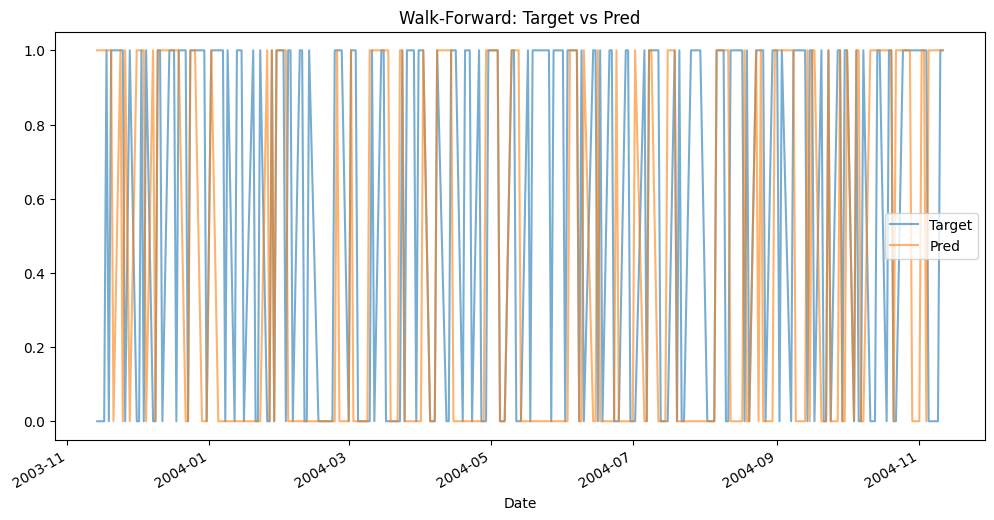

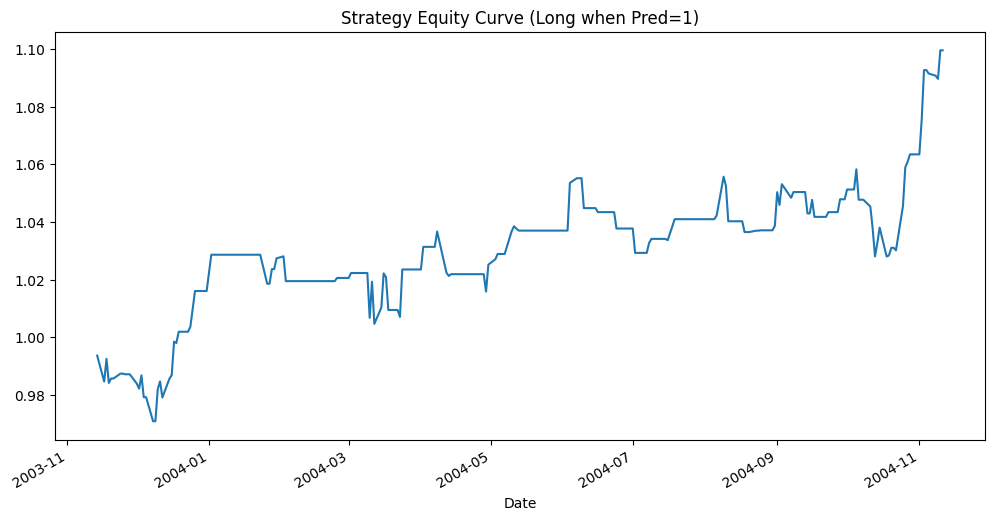

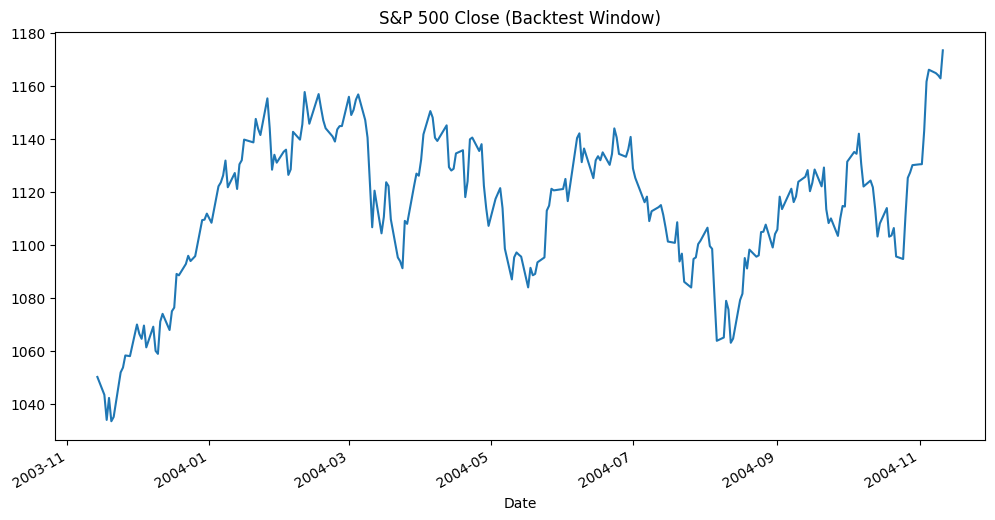

In [29]:
ax = m[["Target","Pred"]].plot(alpha=0.6, title="Walk-Forward: Target vs Pred")
plt.show()

r = sp500.loc[m.index, "Close"].pct_change().shift(-1)
strat = r * m["Pred"]
(eq := (1 + strat.fillna(0)).cumprod()).plot(title="Strategy Equity Curve (Long when Pred=1)")
plt.show()

sp500.loc[m.index, "Close"].plot(title="S&P 500 Close (Backtest Window)")
plt.show()

In [30]:
m["Models"].value_counts()

,count
Models,
rf+gb+xgb,250


In [31]:
m["Thresh"].tail(1)

,Thresh
Date,
2004-11-11 00:00:00-05:00,0.4


In [32]:
last_row = X.iloc[[-1]]
val_pred_list = []
used_models = []
for name, mdl in models:
    try:
        mdl.predict(np.zeros((1, X.shape[1])))
        used_models.append((name, mdl))
    except Exception:
        pass
probs = []
for name, mdl in used_models:
    mdl.fit(X.iloc[:-1], y.iloc[:-1])
    probs.append(mdl.predict_proba(last_row)[:,1])
prob_next = np.mean(np.vstack(probs), axis=0)[0]
latest_thresh = m["Thresh"].iloc[-1]
latest_signal = int(prob_next >= latest_thresh)
{"prob_next": float(prob_next), "threshold": float(latest_thresh), "signal": int(latest_signal)}

{'prob_next': 0.5495949379198753, 'threshold': 0.4, 'signal': 1}